# Seasonal flu vaccines
This exericse predicts whether individuals will receive their seasonal flu vaccines by fitting machine learning models to the U.S. National 2009 H1N1 Flu Survey data. Data is provided courtesy of the United States National Center for Health Statistics to DrivenData for a practice competition (https://www.drivendata.org/competitions/66/flu-shot-learning/).

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

#data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#model selection/ tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

#random forest classifier
from sklearn.ensemble import RandomForestClassifier

#deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#performance metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

In [2]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data checking and cleaning
In this section, read the csv files into pandas Dataframe and perform any necessary checking and cleaning steps. 

In [3]:
#reading training_set_labels 
df_labels = pd.read_csv("./Resources/training_set_labels.csv", index_col = "respondent_id")
df_labels.head(3)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0


In [4]:
#reading training_set_features
df_features = pd.read_csv("./Resources/training_set_features.csv", index_col = "respondent_id")
df_features.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [5]:
#combine both dataframes into a single dataframe
df_vaccine = pd.concat([df_labels,df_features],axis = 1)
df_vaccine.head(3)

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [6]:
#identify h1n1 specific columns
h1n1 = df_vaccine.filter(like = "h1n1").columns
display(h1n1)

#drop h1n1 specific data
df_vaccine.drop(columns = h1n1, inplace = True)

Index(['h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc'],
      dtype='object')

In [7]:
#check for missing values
df_vaccine.isnull().sum()

seasonal_vaccine                   0
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
h

In [8]:
#drop columns with more than 40% missing value
df_vaccine.drop(columns = ["health_insurance","employment_industry","employment_occupation"], inplace= True)

## Exploring the data

In [9]:
#check if seasonal_vaccine has imbalanced classes
df_vaccine["seasonal_vaccine"].value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

Seasonal_vaccine has balanced class.

## Data Preprocessing
**Review the DataFrame, looking for categorical variables that will need to be encoded, as well as columns that could eventually define your features and target variables.**

In [10]:
#review datatype
df_vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   seasonal_vaccine             26707 non-null  int64  
 1   behavioral_antiviral_meds    26636 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_seasonal         24547 non-null  float64
 9   chronic_med_condition        25736 non-null  float64
 10  child_under_6_months         25887 non-null  float64
 11  health_worker                25903 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

In [11]:
df_features = df_vaccine.drop(columns = ["seasonal_vaccine"]).copy()
df_features.head(3)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0


In [12]:
# Create and display the list of numerical variables 
numerical_variables = list(df_features.dtypes[df_features.dtypes != "object"].index)
numerical_variables

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [13]:
# Create a list of categorical variables 
categorical_variables = list(df_features.dtypes[df_features.dtypes == "object"].index)

# Display the categorical variables list
categorical_variables

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

**Replacing missing values with most frequent value**

In [14]:
#define strategy for replacing missing values
imp_mostfreq = SimpleImputer(strategy = "most_frequent", missing_values = np.nan)

In [15]:
#replacing missing values
df_numerical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[numerical_variables].loc[:,:]),
                                              columns = df_features[numerical_variables].columns)

df_numerical_variables_imputed.head(3)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


In [16]:
#replacing missing values
df_categorical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[categorical_variables].loc[:,:]),
                                   columns = df_features[categorical_variables].columns)

df_categorical_variables_imputed.head(3)

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"


**Encode the dataset’s categorical variables using OneHotEncoder, and then place the encoded variables into a new DataFrame.**

In [17]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse = False)

In [18]:
# Encode the categorcal variables using OneHotEncoder
encoded_data = enc.fit_transform(df_categorical_variables_imputed)

In [19]:
# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data,
                          columns = enc.get_feature_names_out(categorical_variables)
                         )

# Review the DataFrame
encoded_df.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


**Add the original DataFrame’s numerical variables to the DataFrame containing the encoded variables.**

In [20]:
# Add the numerical variables from the original DataFrame to the one-hot encoding DataFrame
encoded_df = pd.concat([encoded_df, df_numerical_variables_imputed], axis = 1)

# Review the Dataframe
encoded_df.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


**Define features and target variables**

In [21]:
#define features set X
X = encoded_df.copy()

# Review the features DataFrame
X.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


In [22]:
#define target variable y
y = df_vaccine["seasonal_vaccine"].copy()
y[:5]

respondent_id
0    0
1    1
2    0
3    1
4    0
Name: seasonal_vaccine, dtype: int64

#### Split dataset into training, validation testing dataset

In [23]:
# Creating training, validation, and testing sets
#Split dataset in 80-20; training set is 80% of the total data
#remaining is used for testing and validation
X_train, X_combine, y_train, y_combine = train_test_split(X, y, 
                                                         train_size = 0.8,
                                                         random_state = 10)

In [24]:
#splitting the remaining data in 50-50
#testing set  = 10% of total data
#validation set = 10% of total data
X_val, X_test, y_val, y_test = train_test_split(X_combine, y_combine, 
                                                train_size = 0.50,
                                                random_state = 10)

In [25]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build and Train Machine Learning Model

### Establish the baseline model

In [26]:
# instantiate random forest classifier model instance
rf= RandomForestClassifier(random_state=1)

# Fit the model to the data using the training data
model_rf = rf.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
y_pred_rf = model_rf.predict(X_test_scaled)

# Review the model's predicted values
y_pred_rf[:10]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [27]:
#predict probabilities
prob_pred_rf = model_rf.predict_proba(X_test_scaled)

In [28]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_rf = classification_report(y_test, y_pred_rf)
print(testing_report_rf)

              precision    recall  f1-score   support

           0       0.74      0.79      0.77      1384
           1       0.76      0.70      0.73      1287

    accuracy                           0.75      2671
   macro avg       0.75      0.75      0.75      2671
weighted avg       0.75      0.75      0.75      2671



In [29]:
#get accuracy score
accuracy_base = round(accuracy_score(y_test,y_pred_rf),4)
accuracy_base

0.7514

### Tune the baseline model

#### 1. Features Selection

In [30]:
df = pd.concat([df_vaccine[["seasonal_vaccine"]], encoded_df], axis = 1)
df.head(3)

,seasonal_vaccine,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


In [31]:
#compute correlation matrix
corr = df.corr()
corr.iloc[0,:].sort_values(ascending = False)

seasonal_vaccine                            1.000000
opinion_seas_risk                           0.386916
doctor_recc_seasonal                        0.360696
opinion_seas_vacc_effective                 0.358869
age_group_65+ Years                         0.244830
chronic_med_condition                       0.169465
employment_status_Not in Labor Force        0.145819
health_worker                               0.126977
behavioral_touch_face                       0.119925
behavioral_wash_hands                       0.112254
rent_or_own_Own                             0.101796
race_White                                  0.100314
sex_Female                                  0.077091
behavioral_avoidance                        0.076130
behavioral_large_gatherings                 0.063722
behavioral_outside_home                     0.053287
education_College Graduate                  0.053002
behavioral_face_mask                        0.050020
age_group_55 - 64 Years                     0.

<AxesSubplot: title={'center': 'Correlation Matrix'}>

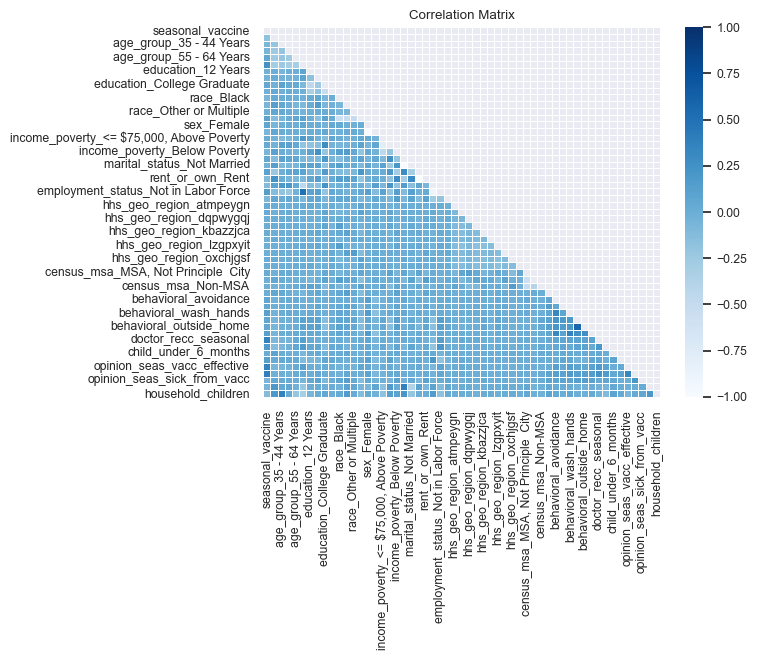

In [32]:
#generate a mast for the uppper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

#plot the correlation matrix
sns.set(font_scale = 0.8)
plt.title("Correlation Matrix")
sns.heatmap(corr, vmin = -1, vmax= 1,cmap = "Blues",
            mask = mask, linewidth =0.5)

In [33]:
#Identify four features that are most correlated with seasonal_vaccine
corr.nlargest(5, corr.columns).index

Index(['seasonal_vaccine', 'opinion_seas_risk', 'doctor_recc_seasonal',
       'opinion_seas_vacc_effective', 'age_group_65+ Years'],
      dtype='object')

In [34]:
#define a new set of features
X2 = encoded_df.filter(['opinion_seas_risk', 'doctor_recc_seasonal','opinion_seas_vacc_effective', 'age_group_65+ Years']).copy()

#review new features dataset
X2.head(3)

,opinion_seas_risk,doctor_recc_seasonal,opinion_seas_vacc_effective,age_group_65+ Years
0,1.0,0.0,2.0,0.0
1,2.0,0.0,4.0,0.0
2,1.0,0.0,4.0,0.0


In [35]:
X2_train, X2_combine, y2_train, y2_combine = train_test_split(X2, y, 
                                                            train_size = 0.8,
                                                            random_state = 10)

X2_val, X2_test, y2_val, y2_test = train_test_split(X2_combine, y2_combine, 
                                                            train_size = 0.5,
                                                            random_state = 10)

In [36]:
# Scale the data
scaler = StandardScaler().fit(X2_train)
X2_train_scaled = scaler.transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

In [37]:
# Fit the model to the data using the training data
model_rf2 = rf.fit(X2_train_scaled, y2_train)

# Use the testing data to make the model predictions
y2_pred_rf = model_rf2.predict(X2_test_scaled)

# Review the model's predicted values
y2_pred_rf[:10]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [38]:
#predict probabilities
prob_pred_rf2 = model_rf2.predict_proba(X2_test_scaled)

In [39]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_rf2 = classification_report(y2_test, y2_pred_rf)
print(testing_report_rf2)

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1384
           1       0.76      0.70      0.72      1287

    accuracy                           0.75      2671
   macro avg       0.75      0.74      0.74      2671
weighted avg       0.75      0.75      0.74      2671



In [40]:
#get accuracy score
accuracy_lessfeature = round(accuracy_score(y2_test,y2_pred_rf),4)
accuracy_lessfeature

0.745

#### 2. Hyperparameters tuning with RandomizedSearchCV

In [41]:
#set up hyperparameter distributions
rscv_params = { "n_estimators":randint(200,501),
                "max_features":randint(10,30),
                "min_samples_split": randint(10,30)
              }

In [42]:
#set up random search meta-estimator
#train 20 models over 2 folds of cross validation (40 models in total)
rscv_search = RandomizedSearchCV(rf,
                                 rscv_params,
                                 n_iter = 20,
                                 cv= 2,
                                 scoring = "accuracy",
                                 verbose = 3,
                                 random_state = 1)

In [43]:
#train the random search meta-estimator to find the best model
tune_rscv = rscv_search.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END max_features=15, min_samples_split=21, n_estimators=272;, score=0.775 total time=   2.4s
[CV 2/2] END max_features=15, min_samples_split=21, n_estimators=272;, score=0.778 total time=   2.4s
[CV 1/2] END max_features=19, min_samples_split=21, n_estimators=333;, score=0.774 total time=   3.4s
[CV 2/2] END max_features=19, min_samples_split=21, n_estimators=333;, score=0.777 total time=   3.5s
[CV 1/2] END max_features=25, min_samples_split=10, n_estimators=344;, score=0.772 total time=   4.8s
[CV 2/2] END max_features=25, min_samples_split=10, n_estimators=344;, score=0.772 total time=   4.8s
[CV 1/2] END max_features=11, min_samples_split=22, n_estimators=271;, score=0.776 total time=   2.0s
[CV 2/2] END max_features=11, min_samples_split=22, n_estimators=271;, score=0.777 total time=   1.9s
[CV 1/2] END max_features=23, min_samples_split=16, n_estimators=481;, score=0.773 total time=   6.0s
[CV 2/2] END max_feat

In [44]:
#display the best hyperparameter values
best_rscv = tune_rscv.best_estimator_.get_params()
display(best_rscv)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 14,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 19,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 441,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [45]:
# Use the best hyperparameters to create a new model
model_rscv = RandomForestClassifier(**best_rscv).fit(X_train_scaled, y_train)

In [46]:
# Use the testing data to make the model predictions
y_pred_rscv = model_rscv.predict(X_test_scaled)
y_pred_rscv[:10]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [47]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_rscv = classification_report(y_test, y_pred_rscv)
print(testing_report_rscv)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1384
           1       0.76      0.73      0.75      1287

    accuracy                           0.76      2671
   macro avg       0.76      0.76      0.76      2671
weighted avg       0.76      0.76      0.76      2671



In [48]:
#get accuracy score
accuracy_rscv = round(accuracy_score(y_test,y_pred_rscv),4)
accuracy_rscv

0.7615

#### 3. Hyperparameters tuning with GridSearchCV

In [49]:
#set up hyperparameter values for grid search
gscv_params = { "n_estimators":[200,500],
                "max_features":[10,15,20],
                "min_samples_split": [20,25,30]
              }

In [50]:
#set up grid search meta-estimator
gscv_search = GridSearchCV(rf,
                           gscv_params,
                           cv=2,
                           scoring = "accuracy",
                           n_jobs = 1,
                           verbose = 3)

In [51]:
tune_gscv = gscv_search.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END max_features=10, min_samples_split=20, n_estimators=200;, score=0.775 total time=   1.4s
[CV 2/2] END max_features=10, min_samples_split=20, n_estimators=200;, score=0.779 total time=   1.4s
[CV 1/2] END max_features=10, min_samples_split=20, n_estimators=500;, score=0.775 total time=   3.6s
[CV 2/2] END max_features=10, min_samples_split=20, n_estimators=500;, score=0.777 total time=   3.6s
[CV 1/2] END max_features=10, min_samples_split=25, n_estimators=200;, score=0.776 total time=   1.3s
[CV 2/2] END max_features=10, min_samples_split=25, n_estimators=200;, score=0.778 total time=   1.3s
[CV 1/2] END max_features=10, min_samples_split=25, n_estimators=500;, score=0.777 total time=   3.5s
[CV 2/2] END max_features=10, min_samples_split=25, n_estimators=500;, score=0.777 total time=   3.5s
[CV 1/2] END max_features=10, min_samples_split=30, n_estimators=200;, score=0.778 total time=   1.3s
[CV 2/2] END max_feat

In [52]:
#display the best hyperparameter values
best_params = gscv_search.best_params_
best_params

{'max_features': 10, 'min_samples_split': 30, 'n_estimators': 200}

In [53]:
# Use the best hyperparameters to create a new model
model_gscv = RandomForestClassifier(**best_params).fit(X_train_scaled, y_train)

In [54]:
# Use the testing data to make the model predictions
y_pred_gscv = model_gscv.predict(X_test_scaled)
y_pred_gscv[:10]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [55]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_gscv = classification_report(y_test, y_pred_gscv)
print(testing_report_gscv)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1384
           1       0.76      0.72      0.74      1287

    accuracy                           0.76      2671
   macro avg       0.76      0.76      0.76      2671
weighted avg       0.76      0.76      0.76      2671



In [56]:
#get accuracy score
accuracy_gscv = round(accuracy_score(y_test,y_pred_gscv),4)
accuracy_gscv

0.7589

### An alternate ML model: Deep learning model

In [57]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

54

In [58]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [59]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = (number_input_features + 1)//2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

27

In [60]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1)//2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

14

In [61]:
# Create the Sequential model instance
nn = Sequential()

In [62]:
# Add the first hidden layer
nn.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

In [63]:
# Add the second hidden layer
nn.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

In [64]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units = number_output_neurons, activation = "sigmoid"))

In [65]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                1485      
                                                                 
 dense_1 (Dense)             (None, 14)                392       
                                                                 
 dense_2 (Dense)             (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Compile the Sequential model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])

In [67]:
# Fit the model using 50 epochs and the training data
epochs = 50
batch_size = 1000

nn.fit(X_train_scaled, y_train, validation_data = (X_val, y_val),
       epochs = epochs, batch_size = batch_size)

Epoch 1/50
22/22 [==============================] - 1s 9ms/step - loss: 0.6592 - accuracy: 0.6105 - val_loss: 0.6753 - val_accuracy: 0.5466
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.5914 - accuracy: 0.6952 - val_loss: 0.6833 - val_accuracy: 0.4972
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.5498 - accuracy: 0.7299 - val_loss: 0.7396 - val_accuracy: 0.4893
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5234 - accuracy: 0.7458 - val_loss: 0.8218 - val_accuracy: 0.4837
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.7569 - val_loss: 0.8977 - val_accuracy: 0.4800
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.7638 - val_loss: 0.9683 - val_accuracy: 0.4759
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.4906 - accuracy: 0.7690 - val_loss: 1.0121 - val_accuracy: 0.4755
Epoch 8/50
22/22 [==

In [68]:
# Use the testing data to make the model predictions
y_pred_nn = (nn.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn[:10]

84/84 [==============================] - 0s 953us/step


array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [69]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn = classification_report(y_test, y_pred_nn)
print(testing_report_nn)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1384
           1       0.76      0.72      0.74      1287

    accuracy                           0.75      2671
   macro avg       0.75      0.75      0.75      2671
weighted avg       0.75      0.75      0.75      2671



In [70]:
#get accuracy score
accuracy_nn = round(accuracy_score(y_test,y_pred_nn),4)
accuracy_nn

0.7537